In [1041]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

plt.style.use('dark_background')

In [1042]:
classification_data, classification_labels = make_classification(n_samples=100, n_features=2,
                              n_informative=2, n_classes=2,
                              n_redundant=0, n_clusters_per_class=1)  # random_state=23 off

In [1043]:
#np.random.seed(42)

In [1044]:
def get_subsample(len_sample):
    sample_indexes = list(range(len_sample))  # number of features
    len_subsample = int(np.round(np.sqrt(len_sample)))  # m = np.sqrt(len(features))
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)  # replace=False => deny repeat indexes

    return subsample

In [1045]:
#get_subsample(5)  # np.round(np.sqrt(5), 2) = 2

In [1046]:
class Node:
    def __init__(self, index, t, left_branch, right_branch, ):
        self.index = index
        self.t = t
        self.left_branch = left_branch
        self.right_branch = right_branch

In [1047]:
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()


    def predict(self):
        classes = {}

        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        prediction = max(classes, key=classes.get)
        return prediction

In [1048]:
def calc_entropy(labels):
    classes = {}

    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    impurity = 0

    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)

    return impurity

In [1049]:
def gain(left_labels, right_labels, root_criterion):
    p_left = left_labels.shape[0] / (left_labels.shape[0] + right_labels.shape[0])

    return root_criterion - p_left * calc_entropy(left_labels) - (1 - p_left) * calc_entropy(right_labels)

In [1050]:
def split(data, labels, column_index, t):
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)

    true_data = data[left]
    false_data = data[right]

    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [1051]:
def find_best_split(data, labels):
    root_entropy = calc_entropy(labels)

    best_gain = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    feature_subsample_indices = get_subsample(n_features)

    for index in feature_subsample_indices:
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            current_gain = gain(true_labels, false_labels, root_entropy)

            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [1052]:
def build_tree(data, labels):
    gain, t, index = find_best_split(data, labels)

    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(index, t, true_branch, false_branch)

In [1053]:
def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.left_branch)
    else:
        return classify_object(obj, node.right_branch)

In [1054]:
def predict(data, tree):
    classes = []

    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)

    return classes

In [1055]:
# from sklearn.model_selection import train_test_split
#
# train_data, test_data, train_labels, test_labels = train_test_split(classification_data,
#                                                                      classification_labels,
#                                                                      test_size=0.3,
#                                                                      random_state=1)

In [1056]:
class Result_forest:

    mean_train_accuracy = 0
    mean_test_accuracy = 0

    def __init__(self, data, labels, n_trees):
        self.data = data
        self.labels = labels
        self.n_trees = n_trees
        self.my_forest = self.random_forest(self.data, self.labels, self.n_trees)

        self.train_indexes = self.my_forest[1]
        self.test_indexes = self.my_forest[2]


    # add OOB indexes
    @staticmethod
    def get_bootstrap(data, labels, N):
        n_samples = data.shape[0]  # 100
        bootstrap = []

        # N - number of trees with subsampling
        for i in range(N):
            sample_index = np.random.randint(0, n_samples, size=n_samples)

            full_index = np.array(range(n_samples))
            unsamples_index = full_index[~np.in1d(full_index, np.unique(sample_index))]

            b_data = data[sample_index]
            b_labels = labels[sample_index]

            bootstrap.append(np.array([b_data, b_labels, sample_index, unsamples_index], dtype=object))

        return np.array(bootstrap)


    def random_forest(self, data, labels, n_trees):
        forest = []
        bootstrap = self.get_bootstrap(data, labels, n_trees)

        boot_indexes = []
        anti_indexes = []


        for b_data, b_labels, boot_index, anti_index in bootstrap:
            forest.append(build_tree(b_data, b_labels))

            boot_indexes.append(boot_index)
            anti_indexes.append(anti_index)

        return forest, boot_indexes, anti_indexes


    @staticmethod
    def tree_vote(forest, data):
        predictions = []
        for tree in forest:
            predictions.append(predict(data, tree))

        predictions_per_object = list(zip(*predictions))

        voted_predictions = []

        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))

        return voted_predictions


    @staticmethod
    def accuracy_metric(actual, predicted):
        correct = 0

        for i in range(len(actual)):
            if actual[i] == predicted[i]:
                correct += 1
        return correct / float(len(actual)) * 100.0


    def show_result(self):
        for train in self.train_indexes:
            train_answers = self.tree_vote(self.my_forest[0], self.data[list(train)])
            train_accuracy = self.accuracy_metric(self.labels[list(train)], train_answers)
            self.mean_train_accuracy += train_accuracy

        for test in self.test_indexes:
            test_answers = self.tree_vote(self.my_forest[0], self.data[list(test)])
            test_accuracy = self.accuracy_metric(self.labels[list(test)], test_answers)
            self.mean_test_accuracy += test_accuracy

        print(f'Train accuracy: {self.mean_train_accuracy / len(self.my_forest[0])}')
        print(f'Test accuracy: {self.mean_test_accuracy / len(self.my_forest[0])}')


    def get_meshgrid(self, data, step=.05, border=1.2):
        x_min , x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


    def show_chart(self):
        colors = ListedColormap(['red', 'blue'])
        light_colors = ListedColormap(['lightcoral', 'lightblue'])

        plt.figure(figsize = (16, 7))
        plt.subplot(1,2,1)
        mesh_predictions = []
        xx = []
        yy = []
        for train in self.train_indexes:
            xx, yy = self.get_meshgrid(self.data[list(train)])

            mesh_predictions = np.array(self.tree_vote(self.my_forest[0], np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
            plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
            plt.scatter(self.data[list(train)][:, 0], self.data[list(train)][:, 1], c=self.labels[list(train)], cmap=colors)
        plt.show()

        plt.subplot(1,2,2)
        for test in self.test_indexes:
            plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
            plt.scatter(self.data[list(test)][:, 0], self.data[list(test)][:, 1], c=self.labels[list(test)], cmap=colors)
        plt.show()

Train accuracy: 100.0
Test accuracy: 97.5


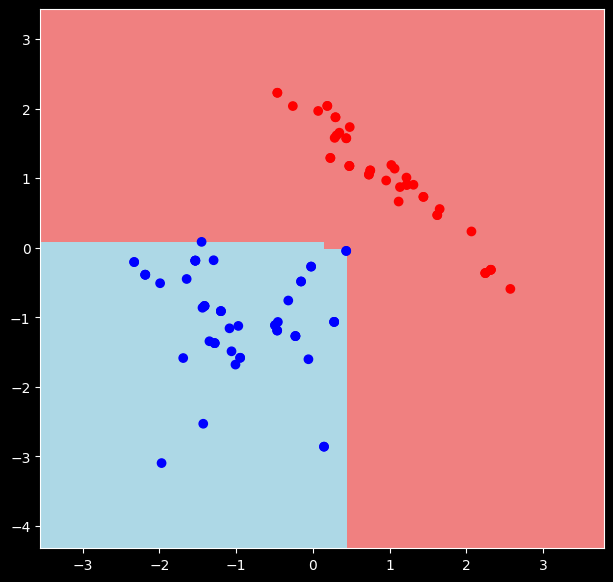

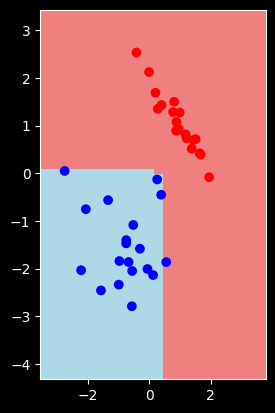

In [1057]:
forest_1 = Result_forest(classification_data, classification_labels, 1)
forest_1.show_result()
forest_1.show_chart()

Train accuracy: 100.0
Test accuracy: 97.41228070175437


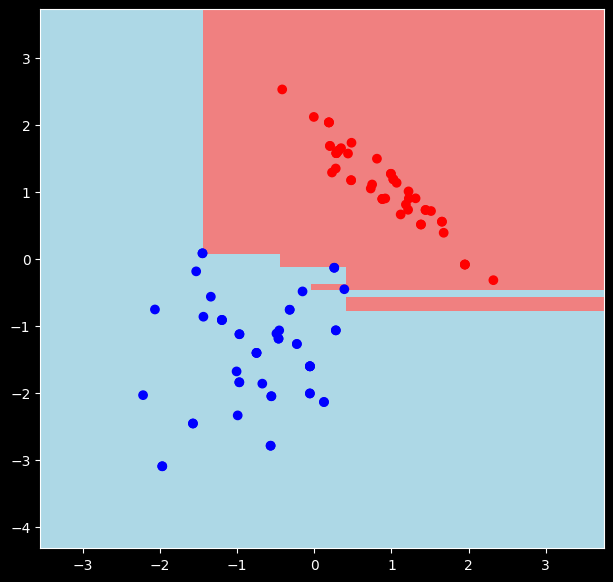

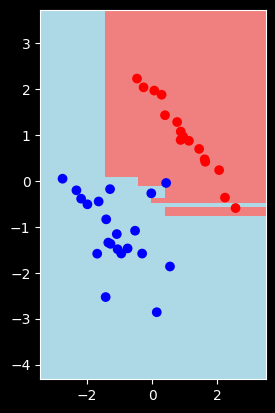

In [1058]:
forest_3 = Result_forest(classification_data, classification_labels, 3)
forest_3.show_result()
forest_3.show_chart()

Train accuracy: 100.0
Test accuracy: 100.0


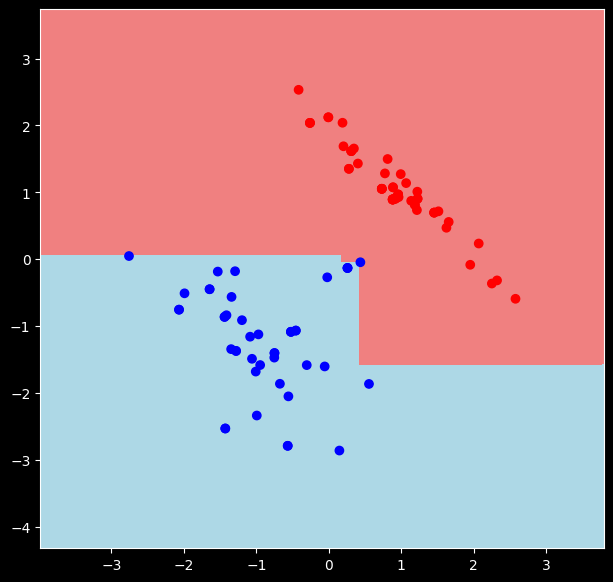

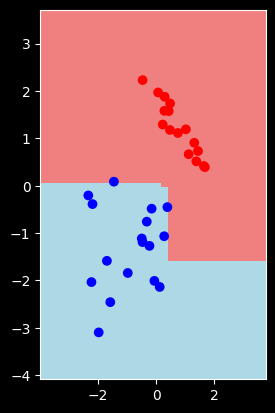

In [1059]:
forest_10 = Result_forest(classification_data, classification_labels, 10)
forest_10.show_result()
forest_10.show_chart()

Train accuracy: 100.0
Test accuracy: 100.0


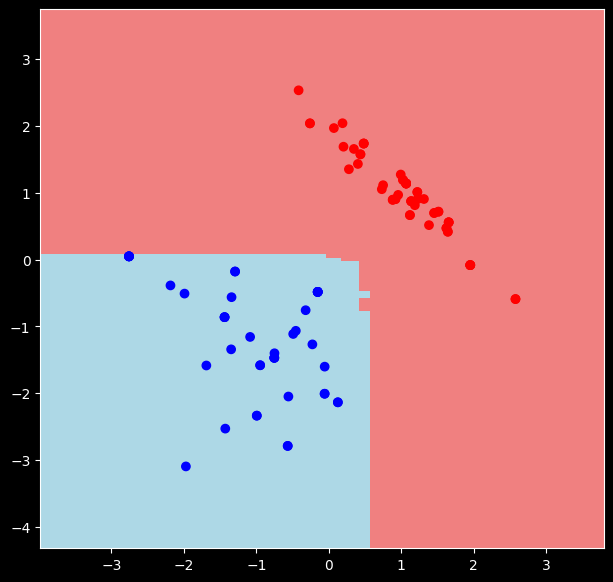

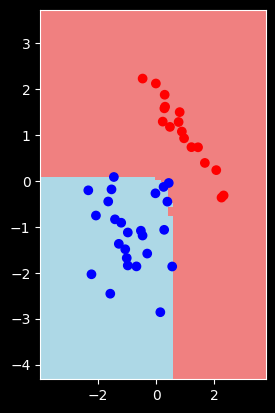

In [1060]:
forest_50 = Result_forest(classification_data, classification_labels, 50)
forest_50.show_result()
forest_50.show_chart()

#### Conclusion:
forest_1 & forest_3 - underfit
forest_10 - good model
forest_50 - good model, but closer to overfit